In [1]:
import torch
%load_ext autoreload
%autoreload 2

In [2]:
original_image = r"data/apples.png"
image_fore = r"data/apples_fore.png"
image_back = r"data/apples_back.png"

In [3]:
from utils.data_utils import ImageDataset
from torch.utils.data import DataLoader

dataset = ImageDataset(original_image, image_fore, image_back)
batch_size = len(dataset) // 2
data_loader = DataLoader(dataset, batch_size, shuffle=True)

all_dataset = ImageDataset(original_image, None, None, train=False)

In [4]:
from models import Network, FlowNetwork
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BCELoss
from utils.training_utils import train

plain_model = Network(5)
convex_model = Network(2, hidden_neurons=80, convex=True)
flow_model = FlowNetwork(2, 50)

optimizer = Adam(list(plain_model.parameters()) + 
                  list(convex_model.parameters()) +
                  list(flow_model.parameters()),
                  lr=1e-2) #, weight_decay=5e-4)
scheduler = None
# scheduler = ReduceLROnPlateau(optimizer, "min", 
#                               verbose=True, min_lr=1e-5)
criterion = BCELoss()
epochs = 550

plain_model, convex_model, flow_model = train(plain_model, convex_model, flow_model,
                                              data_loader, all_dataset,
                                              optimizer, criterion, scheduler, epochs, 
                                              save_log=False)

100%|██████████| 550/550 [01:15<00:00,  7.31it/s]


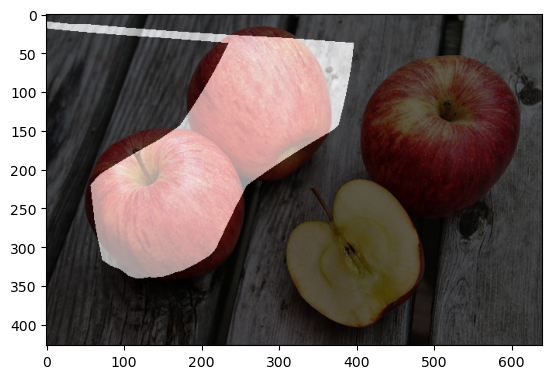

In [5]:
from matplotlib import pyplot as plt
image = plt.imread(original_image)
predictions = convex_model(flow_model(torch.tensor(all_dataset.data[:, :2])))\
                .detach().round().numpy().reshape(image.shape[:2])

plt.imshow(image)
plt.imshow(predictions, cmap="Greys", alpha=0.6)
plt.show()